# MoneyLion - Assignment

### Problem Definition:

Defaulting on loans, credits is one of the biggest challenges companies face in fintech, banking industry. Due to uncertainity, it's hard to eliminate risk of defaults completely but companies can surely mitigate their losses using intelligent risk assessment processes. Machine Learning has provided a sharp edge to companies in anticipating risks and evetually defaults.

From the given data, we infer the following stages in a loan approval process:
1. After the loan application is recieved, a team of automatic / human under-writers do risk assessment and approve the loan.
2. After the loan is approved, it gets funded.

From the business side, there's still a risk of default on funded loans ? What if the loan was approved, funded and yet the client defaulted. Solving this problem would eventually help us in the following ways:
1. Know the chances of defaulting in advance
2. Based on important features from model, use those feature as validation criteria in approval process, hence making the approval process more solid. 

Hence, in tnis problem, we are going to the predict the probability of loan default `loanStatus` out of funded loans.

In [1]:
# load libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
loan = pd.read_csv('data/loan.csv', parse_dates=['applicationDate','originatedDate'])

In [3]:
# consider only funded loans
loan = loan[loan['isFunded'].eq(1)]

In [4]:
loan['loanStatus'].value_counts(normalize=True)

Paid Off Loan                  0.293135
External Collection            0.290750
New Loan                       0.208096
Internal Collection            0.142733
Returned Item                  0.030322
Settlement Paid Off            0.018162
Settled Bankruptcy             0.008337
Pending Paid Off               0.004335
Charged Off Paid Off           0.004079
Settlement Pending Paid Off    0.000026
Charged Off                    0.000026
Name: loanStatus, dtype: float64

### Create a target variable of loan-default

We are going to use `loanStatus` as the target variable. But, we can't use it as is.
We need to define it better for our use case. Since don't have enough information for different values of `loanStatus`, we will consider the levels which seem self-explanatory. <br />

We will categorize the target variable into two classes:
1. <b>Class 0:</b> consists of levels which signifiy that loan was paid
2. <b>Class 1:</b> consists of levels which signifiy that loan was defaulted

For `Class 1`, we will consider the following values:
  * Settled Bankruptcy
  * Charged Off: means the borrower has become delinquent in paying back.
  
For `Class 0`, we will consider the following values:
  * Paid Off Loan
  * Settlement Paid Off

It makes this problem a binary classification problem.

In [5]:
# 1 is default
labels = {1: ['Settled Bankruptcy','Charged Off'], 
          0:['Paid Off Loan','Settlement Paid Off']}

def map_func(x):
    """
    Check if loanStatus if present in the labels dict
    params:
    x = loanStatus, string
    
    returns: label (int)
    """
    for k,v in labels.items():
        if x in v:
            return k

In [6]:
loan['target'] = loan['loanStatus'].map(map_func)
loan2 = loan[loan['target'].notna()].reset_index(drop=True)
loan2['target'] = loan2['target'].astype(int)

In [7]:
prob_1 = loan['target'].value_counts(normalize=True)[0]
prob_0 = loan['target'].value_counts(normalize=True)[1]

In our dataset, we have only {{prob_0}} cases where customers have defaulted. This is a case of imbalanced classification.

## Data Exploration

In [8]:
a, b = loan2.shape

In [9]:
loan2.isna().sum(axis=0).sort_values(ascending=False) / loan2.shape[0]

clarityFraudId                      0.204077
nPaidOff                            0.000562
target                              0.000000
approved                            0.000000
anon_ssn                            0.000000
payFrequency                        0.000000
apr                                 0.000000
applicationDate                     0.000000
originated                          0.000000
originatedDate                      0.000000
isFunded                            0.000000
hasCF                               0.000000
loanStatus                          0.000000
loanAmount                          0.000000
originallyScheduledPaymentAmount    0.000000
state                               0.000000
leadType                            0.000000
leadCost                            0.000000
fpStatus                            0.000000
loanId                              0.000000
dtype: float64

There are multiple ways of exploring this data set (eg: Descriptive & Visual). We will proceed with the descriptive way to be able to follow the exact statistics of the data. Later we will look at some plots for visual understanding.

The given data set belongs to a retail bank. It consist of  values {{a}} observations and {{b}} features. The given data set has few null values also. `clarityFraudId` has 20% missing values.

Should we impute them ? `clarityFraudId` being an identification variable, we shouldn't worry about imputing it. Later we can drop this variable. Let's impute `nPaidOff` using its mode value.

In [10]:
# fill na in nPaidOff by mode value
loan2['nPaidOff'] = loan2['nPaidOff'].fillna(0)

Let's look at the distribution of some variables.

/anaconda3/envs/bunnies/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


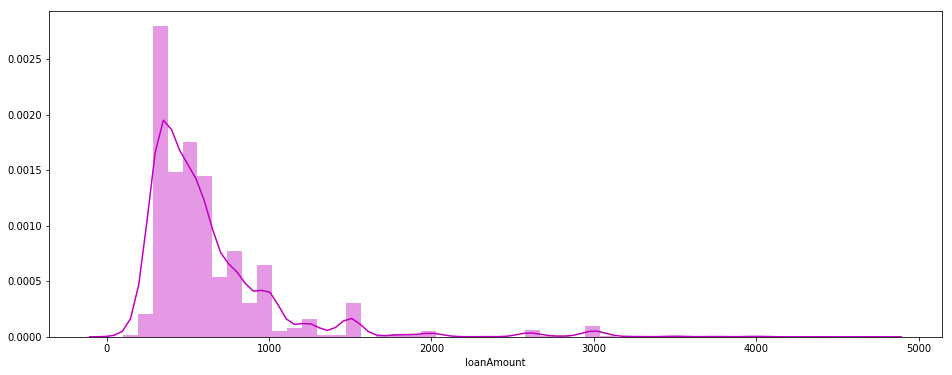

In [11]:
plt.figure(figsize=(16, 6))
sns.distplot(loan2['loanAmount'], color='m')

We see the `loanAmount` is a right skewed variable. Let's see how `loanAmount` varies for each target variable value.

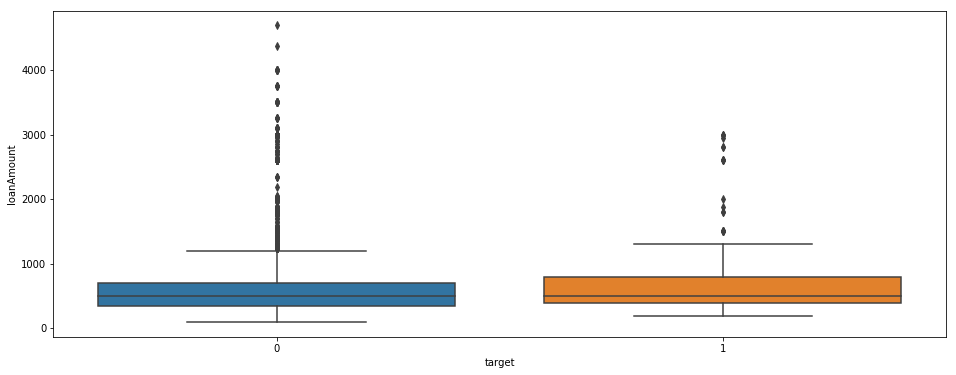

In [12]:
plt.figure(figsize=(16, 6))
sns.boxplot(x = 'target',
            y="loanAmount",
            data=loan2)

It's hard to infer a siginificant difference between the two classes except `class 0` has more outliers. Let's look at at the data in a descriptive way:

In [13]:
# view statistics of all features except id features
vals = ['loanId','clarityFraudId','anon_ssn']
for x in loan2.columns.difference(vals):
    print(x)
    print('-'*100)
    if loan2[x].dtype != 'object':
        print(loan2.groupby('target')[x].describe(percentiles=[.25,.5,.75,.95,.99]))
        print('*'*100)
    else:
        print(loan2.groupby('target')[x].value_counts(normalize=True, ascending=False, sort=True).unstack())

applicationDate
----------------------------------------------------------------------------------------------------
        count unique                         top freq  \
target                                                  
0       12135  12134  2015-02-20 17:16:24.718000    2   
1         326    326  2015-10-27 22:07:58.723000    1   

                             first                        last  
target                                                          
0       2014-12-03 00:31:22.306000  2017-03-18 23:34:27.369000  
1       2015-02-13 18:35:34.286000  2017-03-17 20:49:59.334000  
****************************************************************************************************
approved
----------------------------------------------------------------------------------------------------
        count unique   top   freq
target                           
0       12135      1  True  12135
1         326      1  True    326
***********************************************

Following are some quick insights we can generate from stats above:
1. 14% of the first payment done in defaulted loans got rejected as compared to 2% in non-defaulted loans.
2. Interesting to see that, the mean `leadCost` for defaulted loans is higher than non-default.
3. 46% of the defaulted-loans come from `leadType == bvMandatory`.
4. Clients in defaulted-class have `nPaidOff` mean of 0.32 as compared to 0.59 for non-defaulted loans. It means defaulted clients have lesser paid off loans in past.

### Use information from clarityfraud file

For now, we are going to use only `clearfraudscore` for this file.

In [14]:
clarity = pd.read_csv("data/clarity_underwriting_variables.csv")

/anaconda3/envs/bunnies/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
loan2 = loan2.merge(clarity[['underwritingid','clearfraudscore']], 
                    left_on='clarityFraudId', 
                    right_on='underwritingid', 
                    how='left')

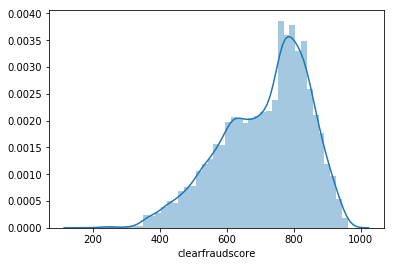

In [16]:
sns.distplot(loan2.loc[loan2['clearfraudscore'].notna(), 'clearfraudscore'])

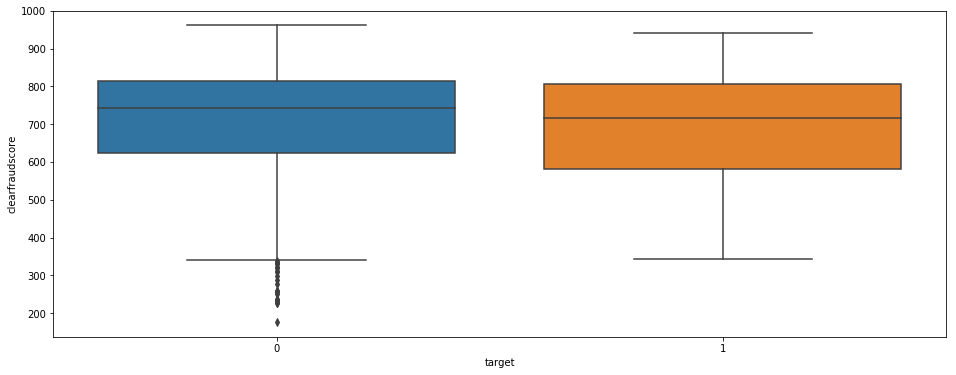

In [17]:
plt.figure(figsize=(16, 6))
sns.boxplot(x = 'target',
            y="clearfraudscore",
            data=loan2.loc[loan2['clearfraudscore'].notna()])

In the histogram, we see that unlike `loanAmount`, `clearfraudscore` is a left skewed variable. We also see that, defaulted-loans have higher minimum value for fraud score, starting around 350 as compared to non-defaulted loans where lower bound of fraud score is below 200. 

Let's look at one more case. We are going to see how `clearfraudscore` varies with `nPaidOff` for each of defaulted and non-defaulted loans.

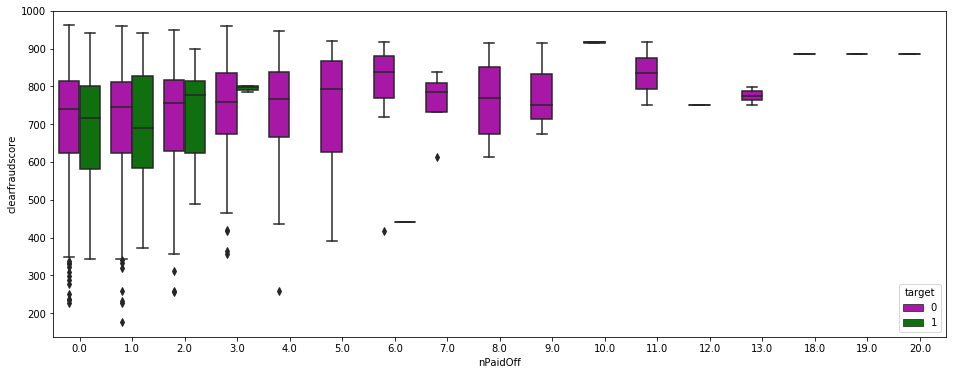

In [18]:
plt.figure(figsize=(16, 6))
sns.boxplot(x="nPaidOff", y="clearfraudscore",
            hue="target", palette=["m", "g"],
            data=loan2[loan2['clearfraudscore'].notna()])

We see that defaulted-loans have `nPaidOff` less than 3 times. On the contrary, we see that people who have paid more (> 6) loans in the past have higher median value for `clearfraudscore`. Since we don't have enough information on this feature, it's hard to come to a conclusion for this behaviour.

## Feature Engineering

After exploring features and understanding their behaviour, now let's create some new features which will can provide more information to our model.

In [19]:
# No. of loans by ssn
loan2['loan_count_per_ssn'] = loan2['anon_ssn'].map(loan2.groupby('anon_ssn')['loanId'].count()).astype(int)

In [20]:
# date features
loan2['time_taken'] = (loan2['originatedDate'] - loan2['applicationDate']).astype('timedelta64[h]').astype(int)
loan2['origin_weekday'] = loan2['originatedDate'].dt.weekday
loan2['accepted_weekday'] = loan2['applicationDate'].dt.weekday
loan2['origin_day'] = loan2['originatedDate'].dt.day
loan2['accepted_day'] = loan2['applicationDate'].dt.day

Let's pick one of the features and see if they make sense.

<Figure size 1152x432 with 0 Axes>

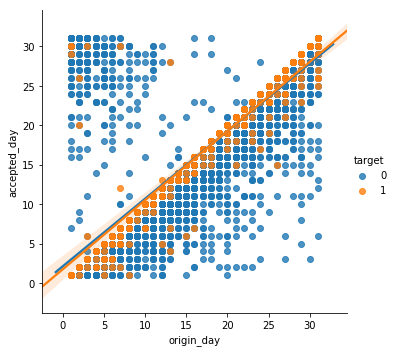

In [21]:
plt.figure(figsize=(16, 6))
sns.lmplot("origin_day", "accepted_day", data=loan2, hue='target')

The straight line is highly dominated by `class 1` which means that loans which are applied and accepted nearly the same day have high default possibility. May be the human approvers process some loans in hurry to meet their targets ? This should be an important feature for the model.

In [22]:
# no of past paid loans by client
loan2['no_paid_off_by_client'] = loan2['anon_ssn'].map(loan.groupby('anon_ssn')['nPaidOff'].sum()).astype(int)

### Encode the categorical variables

Since model accept numeric variables, we need to encode string values into numeric.

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
var = ['payFrequency','leadType','fpStatus','state']

for i in var:
    lbl = LabelEncoder()
    loan2[i + '_en'] = lbl.fit_transform(loan2[i])

In [25]:
all_vars = ['clarityFraudId','underwritingid','originated','approved','isFunded','loanStatus','applicationDate','originatedDate','anon_ssn']

In [26]:
# variables not to be used
loan2 = loan2.drop(var + all_vars, axis=1)

### Use some info payment file

For a quick model, we are going to use only `paymentStatus` information from this file. We are going to count the occurence of `paymentStatus` for each `loanId`.

In [27]:
payment = pd.read_csv('data/payment.csv', parse_dates=['paymentDate'])

In [28]:
# create payment status feature for each loan id
payment['val'] = 1

pay_status = (payment
 .pivot_table(index=['loanId'], columns=['paymentStatus'], values='val', aggfunc=sum, fill_value=0)
 .reset_index()
)

pay_status.columns.name = None

In [29]:
loan2 = (loan2
         .merge(pay_status, on='loanId', how='left')
         .drop(['loanId'], axis=1))

## Prediction Model

We are now ready to train a model. We are going to use a gradient boosting model because of the following reasons:
1. We saw that the some variables are highly skewed. Tree based models are robust to skewness. 
2. The data has some null values, tree based models are robust to null values.
3. Tree based models are robust to outliers, we don't need to worry about them.
4. Tree based model can detect the non-linear behaviour in the data, thus providing better predictions than linear model

We are going to do a 70-30 split for train and validation data respectively.

In [30]:
# import libraries
from sklearn.model_selection import train_test_split
import lightgbm as lgb

/anaconda3/envs/bunnies/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [31]:
data = loan2.copy()

In [32]:
# split into train and test
target = data['target']
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size = 0.3, stratify = target)

X_train = X_train.drop(['target'], axis=1)
X_valid = X_valid.drop(['target'], axis=1)

In [45]:
## params values after parameter tuning
param = {
    'num_leaves': 18,
     'max_bin': 63,
     'min_data_in_leaf': 5,
     'learning_rate': 0.010614430970330217,
     'min_sum_hessian_in_leaf': 0.0093586657313989123,
     'feature_fraction': 0.056701788569420042,
     'min_gain_to_split': 0.29588543202055562,
     'max_depth': 3,
     'save_binary': True,
     'seed': 1337,
     'objective': 'binary',
     'boosting_type': 'gbdt',
     'verbose': 1,
     'metric': 'auc',
     'is_unbalance': True,
     'boost_from_average': False
}

In [46]:
xg_train = lgb.Dataset(X_train.values,
                           label=y_train.values,
                           feature_name=X_train.columns.tolist(),
                           free_raw_data = False
                           )
xg_valid = lgb.Dataset(X_valid.values,
                       label=y_valid.values,
                       feature_name=X_train.columns.tolist(),
                       free_raw_data = False
                       )   

In [47]:
clf = lgb.train(param, 
                xg_train,
                5000, 
                valid_sets = [xg_train, xg_valid], 
                verbose_eval=100,
                early_stopping_rounds=400)

Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.916461	valid_1's auc: 0.880823
[200]	training's auc: 0.93169	valid_1's auc: 0.891345
[300]	training's auc: 0.933359	valid_1's auc: 0.886802
[400]	training's auc: 0.940533	valid_1's auc: 0.893259
[500]	training's auc: 0.945299	valid_1's auc: 0.894313
[600]	training's auc: 0.94756	valid_1's auc: 0.897124
[700]	training's auc: 0.949487	valid_1's auc: 0.90021
[800]	training's auc: 0.952766	valid_1's auc: 0.904265
[900]	training's auc: 0.954688	valid_1's auc: 0.904102
[1000]	training's auc: 0.955847	valid_1's auc: 0.90614
[1100]	training's auc: 0.957259	valid_1's auc: 0.907594
[1200]	training's auc: 0.958776	valid_1's auc: 0.909141
[1300]	training's auc: 0.959744	valid_1's auc: 0.910736
[1400]	training's auc: 0.96122	valid_1's auc: 0.912053
[1500]	training's auc: 0.962198	valid_1's auc: 0.913426
[1600]	training's auc: 0.963241	valid_1's auc: 0.913808
[1700]	training's auc: 0.96414	valid_1's auc: 0.91552
[

<strong>Note:</strong> We see that the model returns 0.92 AUC score on validation set. We are using AUC here because:
1. Since it's an imbalanced problem, for our case, we need to be sure about false negatives. We can`t use a global metric such as accuracy since it would capture the overall performance of the model and not on a per class basis.
2. AUC will help us detect the false positive, because usually for companies commiting false negatives have high business cost.

## Feature Importance

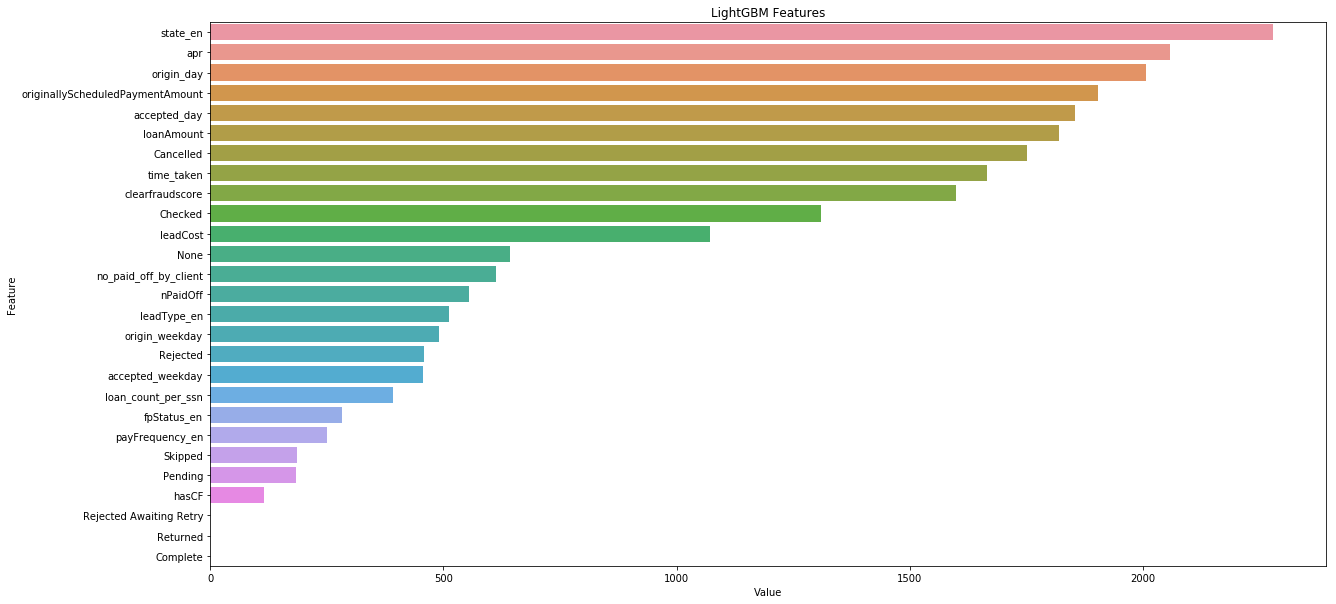

In [272]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.show()

## Summary

In this report, we achieved 0.92 AUC score in determining whether a loan will be defaulted or not. We explored past loan performance and understood i.e. what kind of people are more likely to default. We also learned that the given problem is an imbalanced problem, hence we need to very careful in deciding model evaluation. We cannot use global metrics like accuracy which are mis-leading in this case.

## Next Steps
1. Get more data on `loanIds` which are funded. 
2. Use more information `clarity_underwriting` file and train a model using all those features.
3. Do more feature engineering
   * Create more aggregated features by `client_id`, `state`, `payFrequency`.
   * Create more aggregated features from `payment` file.
4. Do feature selection. Based on feature importance discard variables which aren't important.
5. Try different models
6. Ensemble models: train different models and average their predictions.
7. Stack Models: train different models and use their predictions as features in another model.
8. Using confusion matrix, analyse false negative cases and check why is model failing there.